<font face="Arial" color="navy" size=12>Convolutional Neural Networks</font>

In [ ]:
#@title
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore')

## Keras & Tensorflow Libraries - these are GPU libraries




In [ ]:
import tensorflow as tf

# example of loading the mnist dataset
from sklearn.model_selection import StratifiedKFold
#from sklearn.preprocessing import OneHotEncoder
# here we get close to the original format of MNIST this is 28x28 pixels for each image
from keras.datasets import mnist
from keras.models import Sequential # most of the time we design a "sequence" of layers
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
#from __future__ import print_function
import numpy as np
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator # to create realistic geometrical deformations of the images
from tensorflow.keras.utils import to_categorical # this does the same as OneHotEncoder
# we import a lot of network design specific functions that we may need
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import LeakyReLU, ReLU
from keras.regularizers import l1, l2, l1_l2
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
import os
from tensorflow.python.framework import ops

In [ ]:
# this would be used later for "transfer learning"
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image

## Examples of Convolutional Neural Network on the MNIST Data

11490434/11490434 [==============================] - 1s 0us/step
Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


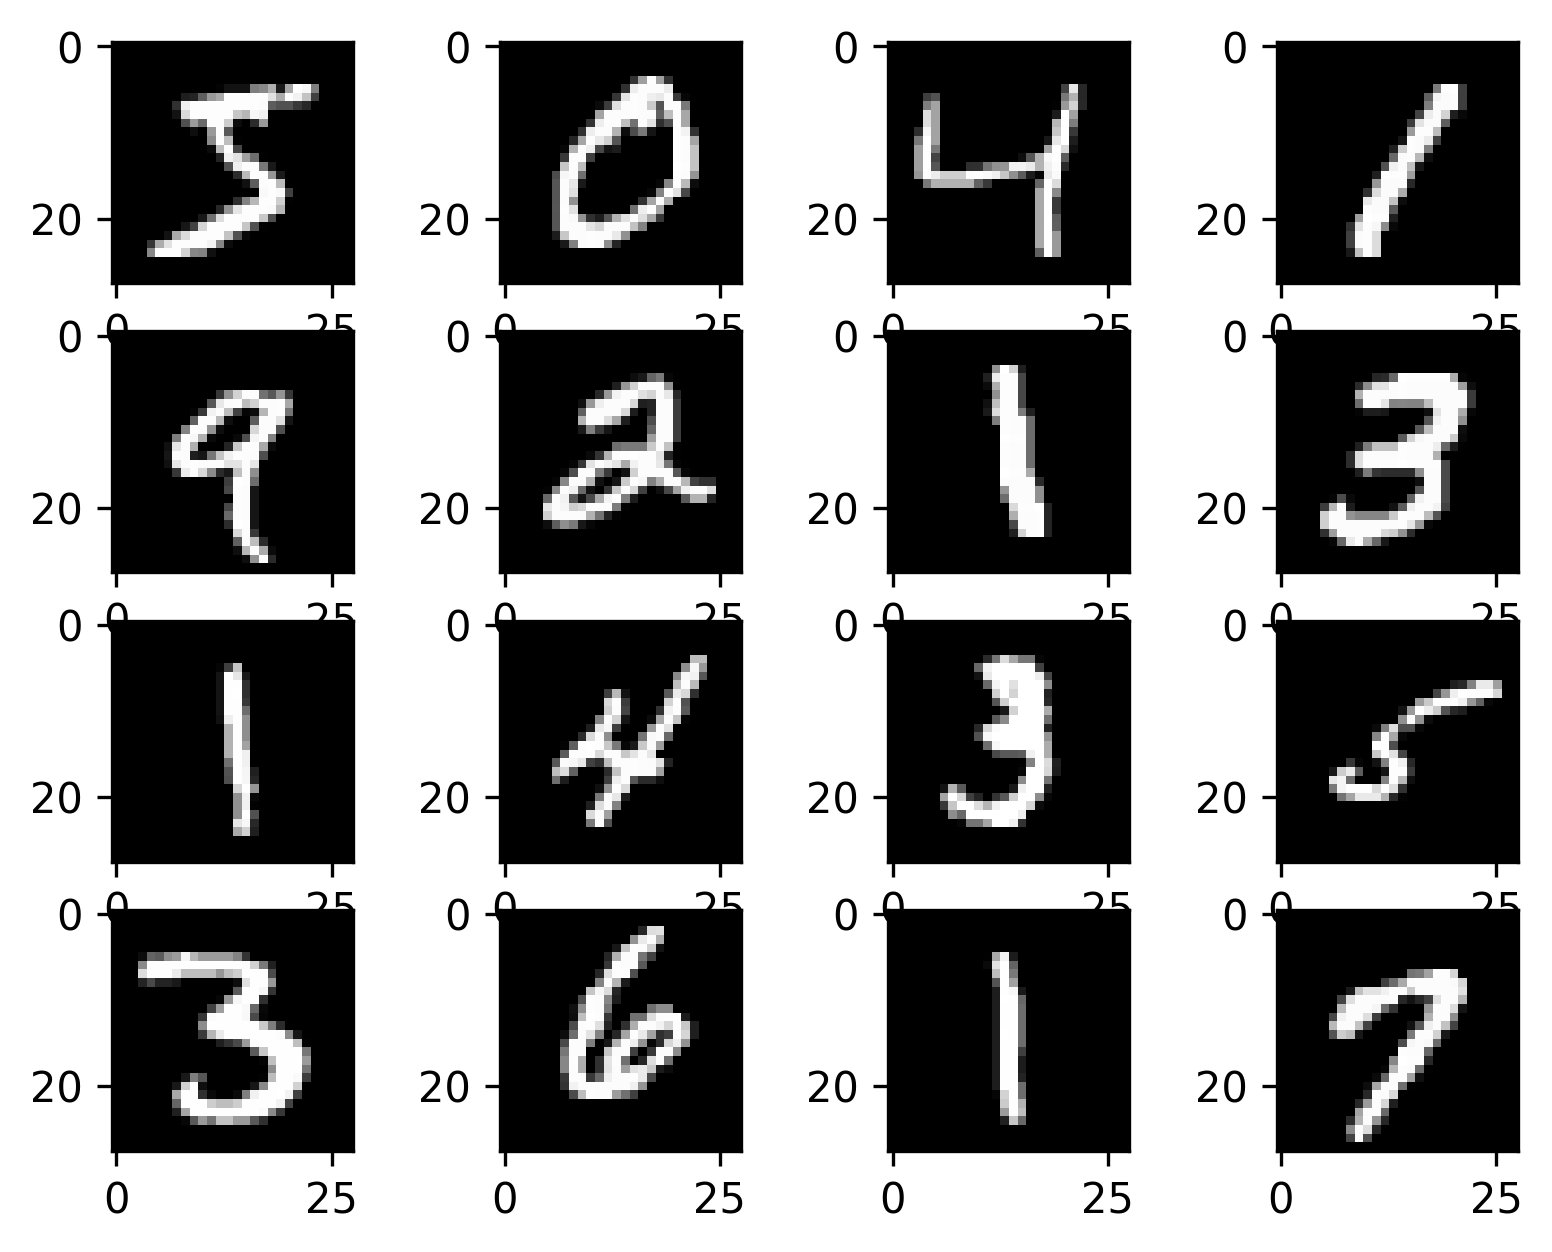

In [ ]:
# load dataset - this is a different version of MNIST compared to sklearn
(trainX, trainy), (testX, testy) = mnist.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))
# plot first few images
for i in range(16):
	# define subplot
	plt.subplot(4,4,i+1)
	# plot raw pixel data
	plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

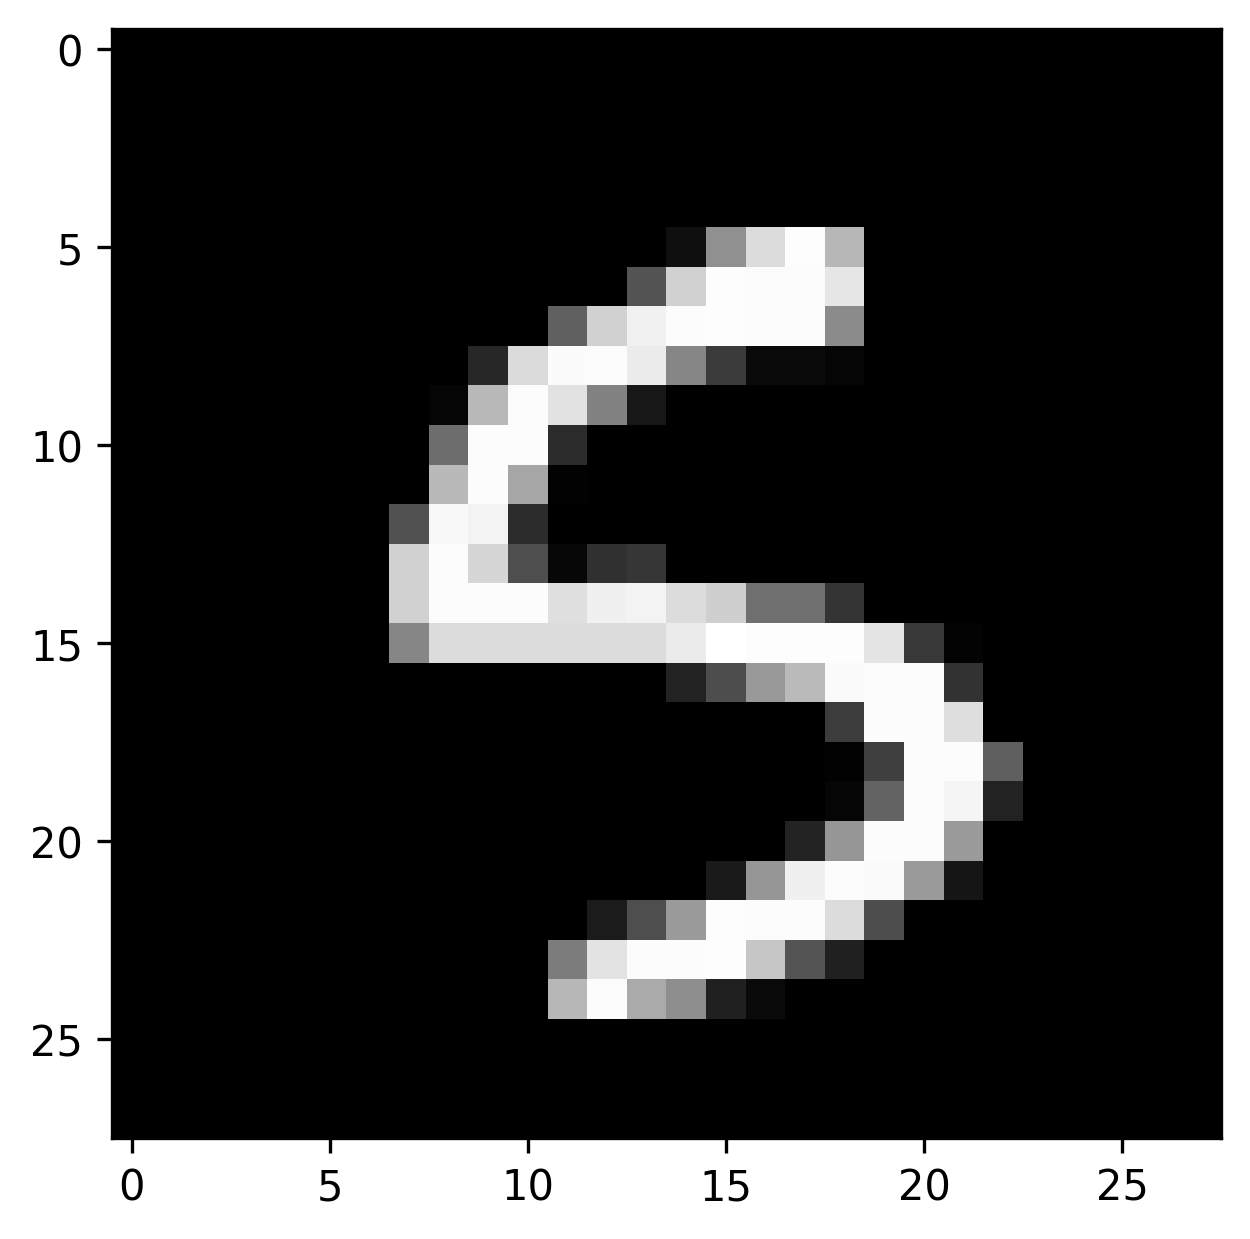

In [ ]:
plt.imshow(trainX[15000], cmap=plt.get_cmap('gray'))

In [ ]:
trainy[15000]

5

One Hot Encoder

The idea is that 5 is represented by:

$$\large \left(0,0,0,0,0,1,0,0,0,0\right)$$

In [ ]:
trainy[3245]

6

In [ ]:
# for one hot encoding we can use the provided "to_categorical" function from Tensorflow
ytrain = to_categorical(trainy)
ytest = to_categorical(testy)

In [ ]:
ytrain[15000]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

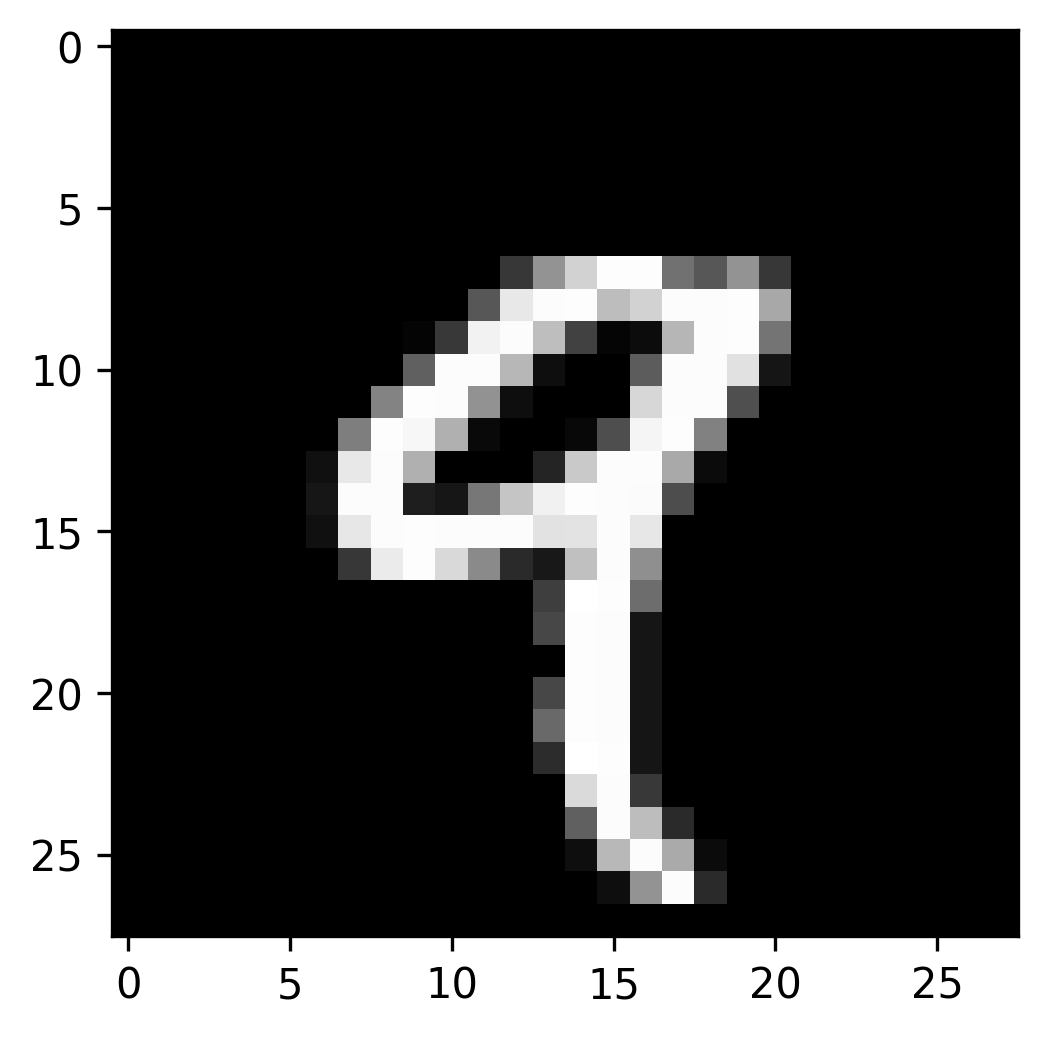

In [ ]:
plt.imshow(trainX[4],cmap=plt.get_cmap('gray'))

In [ ]:
trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))

In [ ]:
trainX.shape

(60000, 28, 28)

In [ ]:
testX.shape

(10000, 28, 28)

### Define the Convolutional Model

We are following the overall idea of the design:

- we have an input gate
- we have layers of convolutions intersperced with normalization and summarization.
- we have a prep for the thinking neurons (typically we flatten the output of convolutions)
- we have the "thinking" neurons
- we have the output layer that is preparing the probability values for each class.


In [ ]:
# here we make the first CNN
model = Sequential() # always the case
# in the beginning we make convolutions (useful distortions)
model.add(Conv2D(137, (3,3), kernel_initializer='he_uniform', input_shape=(28, 28, 1))) # extracting artificial features
model.add(BatchNormalization()) # this is like a Standard Scaler
model.add(MaxPooling2D(pool_size=(2,2))) # data summarization is for memory management
model.add(Dropout(0.1))
model.add(Conv2D(53,(3,3))) # more features extracted
model.add(BatchNormalization()) # standardization
model.add(MaxPooling2D((2, 2))) # maybe we had enough many convolutions
model.add(Dropout(0.1))
model.add(Flatten()) # we collect all the extracted features and feed them into the "thinking neurons"
# here we have the layers of neurons that helps with the actual classification problem
model.add(Dense(169, activation=LeakyReLU(alpha=0.1), kernel_initializer='he_uniform',kernel_regularizer=l2(0.001)))
# the following is the output layer
model.add(Dense(10, activation='softmax')) # this is non-negotiable, this is the output layer
# compile model
opt = Adam(learning_rate=0.002)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

How exactly are the probability values computed?

Answer: by using the "softmax" function:

$$\large p_i= \frac{e^{\text {linear combination i}}}{\sum_{i=1}^{K} e^{\text{linear combination i}}}$$

## Fit the Network

In [ ]:
model.fit(trainX, ytrain, epochs=30, batch_size=50, validation_data=(testX, ytest), verbose=1)

Epoch 1/30
1200/1200 [==============================] - 19s 7ms/step - loss: 0.3328 - accuracy: 0.9535 - val_loss: 0.1472 - val_accuracy: 0.9799
Epoch 2/30
1200/1200 [==============================] - 8s 7ms/step - loss: 0.1473 - accuracy: 0.9765 - val_loss: 0.1294 - val_accuracy: 0.9807
Epoch 3/30
1200/1200 [==============================] - 8s 7ms/step - loss: 0.1357 - accuracy: 0.9795 - val_loss: 0.1157 - val_accuracy: 0.9830
Epoch 4/30
1200/1200 [==============================] - 8s 7ms/step - loss: 0.1241 - accuracy: 0.9814 - val_loss: 0.1262 - val_accuracy: 0.9803
Epoch 5/30
1200/1200 [==============================] - 8s 7ms/step - loss: 0.1218 - accuracy: 0.9814 - val_loss: 0.1091 - val_accuracy: 0.9841
Epoch 6/30
1200/1200 [==============================] - 8s 7ms/step - loss: 0.1160 - accuracy: 0.9823 - val_loss: 0.1043 - val_accuracy: 0.9835
Epoch 7/30
1200/1200 [==============================] - 8s 7ms/step - loss: 0.1086 - accuracy: 0.9837 - val_loss: 0.1056 - val_accuracy

In [ ]:
#@title
# improvements
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),input_shape=(28, 28, 1)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2))) # for downsizing the info from the features a bit
model.add(Dropout(0.25)) # to prevent having dead neurons
model.add(Conv2D(64, kernel_size=(3, 3)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25)) # to prevent inactive neurons
model.add(Flatten())
model.add(Dense(200))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(10, activation='softmax'))
opt = Adam(learning_rate=0.002)
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

In [ ]:
# let's try the updated model
model.fit(trainX, ytrain, epochs=30, batch_size=40, validation_data=(testX, ytest), verbose=1)

Epoch 1/30
1500/1500 [==============================] - 8s 4ms/step - loss: 0.6553 - accuracy: 0.9322 - val_loss: 0.2114 - val_accuracy: 0.9425
Epoch 2/30
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1107 - accuracy: 0.9673 - val_loss: 0.0521 - val_accuracy: 0.9826
Epoch 3/30
1500/1500 [==============================] - 5s 4ms/step - loss: 0.1055 - accuracy: 0.9694 - val_loss: 0.0532 - val_accuracy: 0.9833
Epoch 4/30
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1113 - accuracy: 0.9701 - val_loss: 0.0816 - val_accuracy: 0.9785
Epoch 5/30
1500/1500 [==============================] - 5s 4ms/step - loss: 0.1247 - accuracy: 0.9687 - val_loss: 0.0659 - val_accuracy: 0.9818
Epoch 6/30
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1224 - accuracy: 0.9701 - val_loss: 0.0920 - val_accuracy: 0.9748
Epoch 7/30
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1201 - accuracy: 0.9717 - val_loss: 0.0733 - val_accuracy:

### Import the Data

In [ ]:
(trainX, trainY), (testX, testY) = mnist.load_data()
xtrain = trainX.reshape((trainX.shape[0], 28, 28, 1))
xtest = testX.reshape((testX.shape[0], 28, 28, 1))

In [ ]:
xtrain.shape

(60000, 28, 28, 1)

### IMPORTANT: Normalize the Data

In [ ]:
# making sure data is available in the correct format for fitting the model
xtrain_norm = xtrain.astype('float32')
xtest_norm = xtest.astype('float32')
# normalize to range 0-1x
xtrain_norm = xtrain_norm / 255.0
xtest_norm = xtest_norm / 255.0
ytrain = to_categorical(trainy)
ytest = to_categorical(testy)

### Fit the Model

In [ ]:
model.fit(xtrain_norm, ytrain, epochs=30, batch_size=50, validation_data=(xtest_norm, ytest), verbose=1)

Epoch 1/30
1200/1200 [==============================] - 6s 4ms/step - loss: 0.1300 - accuracy: 0.9592 - val_loss: 0.0364 - val_accuracy: 0.9873
Epoch 2/30
1200/1200 [==============================] - 4s 3ms/step - loss: 0.0540 - accuracy: 0.9832 - val_loss: 0.0294 - val_accuracy: 0.9899
Epoch 3/30
1200/1200 [==============================] - 4s 3ms/step - loss: 0.0408 - accuracy: 0.9872 - val_loss: 0.0312 - val_accuracy: 0.9898
Epoch 4/30
1200/1200 [==============================] - 4s 3ms/step - loss: 0.0339 - accuracy: 0.9893 - val_loss: 0.0290 - val_accuracy: 0.9906
Epoch 5/30
1200/1200 [==============================] - 4s 3ms/step - loss: 0.0310 - accuracy: 0.9901 - val_loss: 0.0258 - val_accuracy: 0.9921
Epoch 6/30
1200/1200 [==============================] - 4s 3ms/step - loss: 0.0287 - accuracy: 0.9908 - val_loss: 0.0321 - val_accuracy: 0.9909
Epoch 7/30
1200/1200 [==============================] - 4s 3ms/step - loss: 0.0252 - accuracy: 0.9920 - val_loss: 0.0319 - val_accuracy:

In [ ]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 26, 26, 256)       2560      
                                                                 
 batch_normalization_6 (Batc  (None, 26, 26, 256)      1024      
 hNormalization)                                                 
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 6, 6, 256)        0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 4, 4, 192)         442560    
                                                                 
 batch_normalization_7 (Batc  (None, 4, 4, 192)        768       
 hNormalization)                                                 
                                                      

In [ ]:
model.weights

In [ ]:
# load train and test dataset
def load_dataset():
	# load dataset
	(trainX, trainY), (testX, testY) = mnist.load_data()
	# reshape dataset to have a single channel
	trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
	testX = testX.reshape((testX.shape[0], 28, 28, 1))
	# one hot encode target values
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return trainX, trainY, testX, testY

# scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

## IMPORTANT !!!
# This is the Design of the Convolutional Neural Network model
def define_model():
	model = Sequential()
	# in the beginning we make convolutions (useful distortions)
	model.add(Conv2D(256, (3,3),
										kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(BatchNormalization())
	model.add(MaxPooling2D(pool_size=(4,4)))
	model.add(Conv2D(192,(3,3)))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((3, 3)))
	model.add(Flatten())
	# here we have the layers of neurons that helps with the actual classification problem
	model.add(Dense(200, activation=LeakyReLU(alpha=0.1), kernel_initializer='he_uniform'))
	model.add(Dense(200, activation=LeakyReLU(alpha=0.1), kernel_initializer='he_uniform',kernel_regularizer=l2(0.02)))
	# the following is the output layer
	model.add(Dense(10, activation='softmax'))
	# compile model
	#opt = SGD(lr=0.01, momentum=0.9)
	opt = Adam(learning_rate=0.0005)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

# evaluate a model using stratified k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
	scores, histories = list(), list()
	# prepare cross validation
	kfold = StratifiedKFold(n_folds, shuffle=True, random_state=1234)
	# enumerate splits
	for train_ix, test_ix in kfold.split(dataX,trainy):
		# define model
		model = define_model()
		# select rows for train and test
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		# fit model
		history = model.fit(trainX, trainY, epochs=20, batch_size=50, validation_data=(testX, testY), verbose=0)
		# evaluate model
		_, acc = model.evaluate(testX, testY, verbose=0)
		print('> %.3f' % (acc * 100.0))
		# stores scores
		scores.append(acc)
		histories.append(history)
	return scores, histories, model

# plot diagnostic learning curves
def summarize_diagnostics(histories):
	for i in range(len(histories)):
		# plot loss
		plt.subplot(2, 1, 1)
		plt.title('Cross Entropy Loss')
		plt.plot(histories[i].history['loss'], color='blue', label='train')
		plt.plot(histories[i].history['val_loss'], color='orange', label='test')
		# plot accuracy
		plt.subplot(2, 1, 2)
		plt.title('Classification Accuracy')
		plt.plot(histories[i].history['accuracy'], color='blue', label='train')
		plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
		plt.tight_layout(pad=3.0)
	plt.show()

# summarize model performance
def summarize_performance(scores):
	# print summary
	print('Accuracy: mean=%.3f std=%.3f, n=%d' % (np.mean(scores)*100, np.std(scores)*100, len(scores)))
	# box and whisker plots of results
	plt.boxplot(scores)
	plt.show()

# run the test harness for evaluating a model
def run_everything():
	vals= []
	# load dataset
	trainX, trainY, testX, testY = load_dataset()
	# prepare pixel data
	trainX, testX = prep_pixels(trainX, testX)
	# evaluate model
	scores, histories, model = evaluate_model(trainX, trainY)
	# learning curves
	vals.append(scores)
	summarize_diagnostics(histories)
	# summarize estimated performance
	summarize_performance(scores)
	print('The overall accuracy is :'+str(np.mean(vals)))
	return model


> 98.067
> 96.583
> 97.842
> 98.617
> 98.258


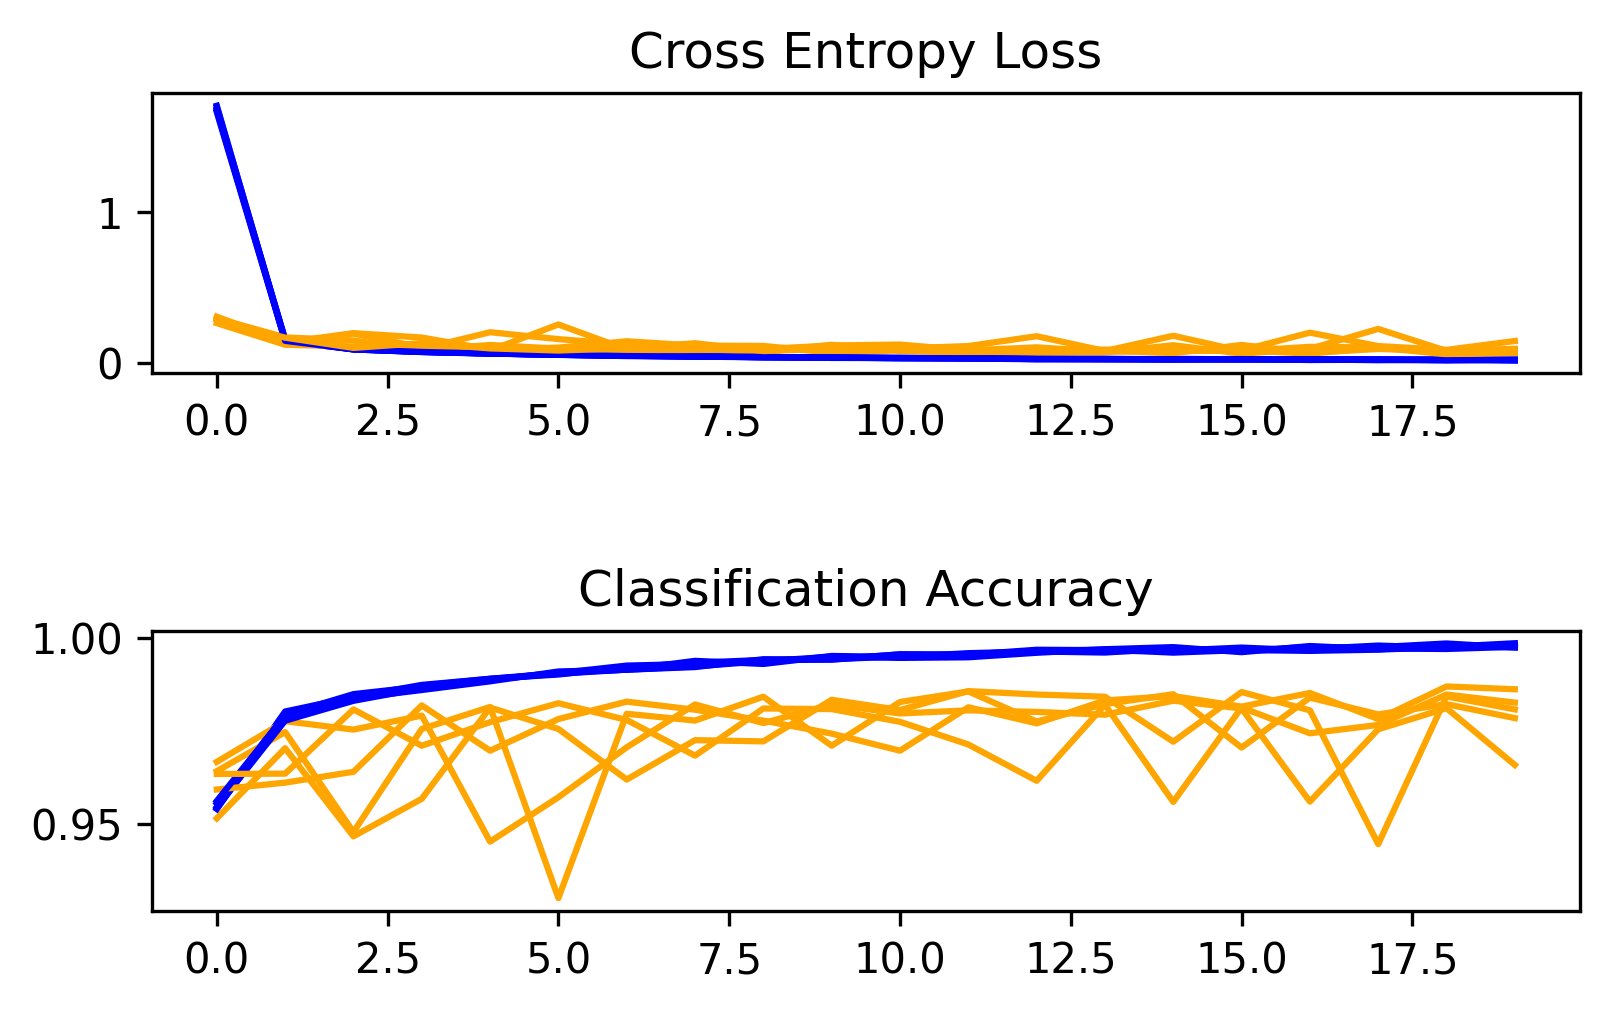

Accuracy: mean=97.873 std=0.693, n=5


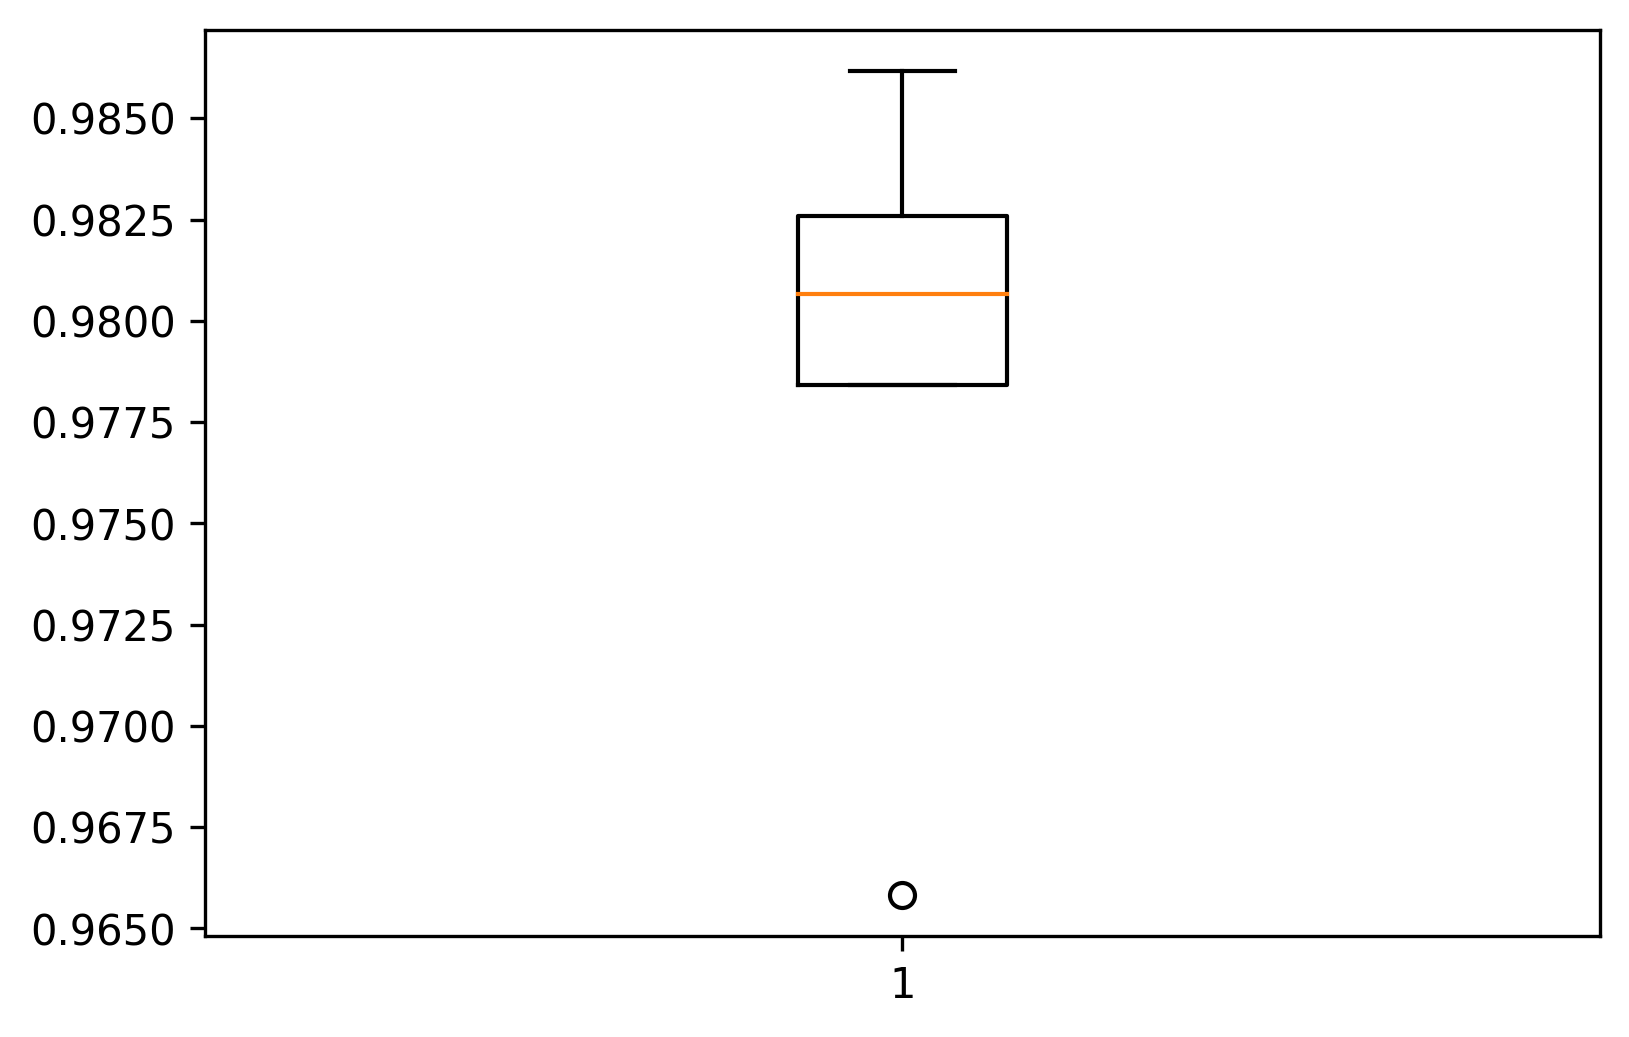

The overall accuracy is :0.9787333250045777


In [ ]:
model = run_everything()

In [ ]:
model = define_model()

In [ ]:
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 26, 26, 128)       1280      
                                                                 
 batch_normalization_48 (Bat  (None, 26, 26, 128)      512       
 chNormalization)                                                
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 6, 6, 128)        0         
 g2D)                                                            
                                                                 
 conv2d_49 (Conv2D)          (None, 4, 4, 128)         147584    
                                                                 
 batch_normalization_49 (Bat  (None, 4, 4, 128)        512       
 chNormalization)                                                
                                                     

In [ ]:
from keras.utils import plot_model

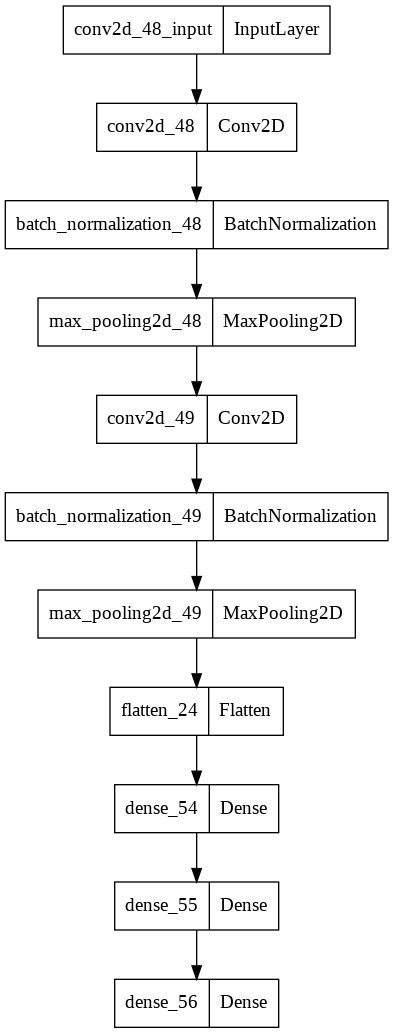

In [ ]:
plot_model(model)

In [ ]:
model.save('model_mnistv1.h5')

## Improving Accuracy on the MNIST data with CNN's

In [ ]:


# what we need to design the CNN
# from tensorflow.keras.layers import Dense, Activation
# from keras.layers import LeakyReLU, ReLU
# from keras.layers import Dropout


# load train and test dataset
# def load_dataset():
# 	# load dataset
# 	(trainX, trainY), (testX, testY) = mnist.load_data()
# 	# reshape dataset to have a single channel
# 	trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
# 	testX = testX.reshape((testX.shape[0], 28, 28, 1))
# 	# one hot encode target values
# 	trainY = to_categorical(trainY)
# 	testY = to_categorical(testY)
# 	return trainX, trainY, testX, testY

# scale pixels
# def prep_pixels(train, test):
# 	# convert from integers to floats
# 	train_norm = train.astype('float32')
# 	test_norm = test.astype('float32')
# 	# normalize to range 0-1
# 	train_norm = train_norm / 255.0
# 	test_norm = test_norm / 255.0
# 	# return normalized images
# 	return train_norm, test_norm

# This is the Design of the Convolutional Neural Network model
def define_model():
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3),input_shape=(28, 28, 1)))
  model.add(LeakyReLU(alpha=0.1))
  model.add(MaxPooling2D(pool_size=(2, 2))) # for downsizing the info from the features a bit
  model.add(Dropout(0.25)) # to prevent having dead neurons
  model.add(Conv2D(64, kernel_size=(3, 3)))
  model.add(LeakyReLU(alpha=0.1))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(200))
  model.add(LeakyReLU(alpha=0.1))
  model.add(Dense(10, activation='softmax'))
  opt = Adam(learning_rate=0.002)
  model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
  return model


# evaluate a model using k-fold cross-validation
# def evaluate_model(dataX, dataY, n_folds=10):
# 	scores, histories = list(), list()
# 	# prepare cross validation
# 	kfold = StratifiedKFold(n_folds, shuffle=True, random_state=1234)
# 	# enumerate splits
# 	for train_ix, test_ix in kfold.split(dataX,trainy):
# 		# define model
# 		model = define_model()
# 		# select rows for train and test
# 		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
# 		# fit model
# 		history = model.fit(trainX, trainY, epochs=25, batch_size=100, validation_data=(testX, testY), verbose=0)
# 		# evaluate model
# 		_, acc = model.evaluate(testX, testY, verbose=0)
# 		print('> %.3f' % (acc * 100.0))
# 		# stores scores
# 		scores.append(acc)
# 		histories.append(history)
# 	return scores, histories



In [ ]:
# plot diagnostic learning curves
# def summarize_diagnostics(histories):
# 	for i in range(len(histories)):
# 		# plot loss
# 		plt.subplot(2, 1, 1)
# 		plt.title('Cross Entropy Loss')
# 		plt.plot(histories[i].history['loss'], color='blue', label='train')
# 		plt.plot(histories[i].history['val_loss'], color='orange', label='test')
# 		# plot accuracy
# 		plt.subplot(2, 1, 2)
# 		plt.title('Classification Accuracy')
# 		plt.plot(histories[i].history['accuracy'], color='blue', label='train')
# 		plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
# 		plt.tight_layout(pad=3.0)
# 	plt.show()

# # summarize model performance
# def summarize_performance(scores):
# 	# print summary
# 	print('Accuracy: mean=%.3f std=%.3f, n=%d' % (np.mean(scores)*100, np.std(scores)*100, len(scores)))
# 	# box and whisker plots of results
# 	plt.boxplot(scores)
# 	plt.show()

# run the test harness for evaluating a model
def run_everything_again():
	# load dataset
	trainX, trainY, testX, testY = load_dataset()
	# prepare pixel data
	trainX, testX = prep_pixels(trainX, testX)
	# evaluate model
	scores, histories, model = evaluate_model(trainX, trainY)
	# learning curves
	summarize_diagnostics(histories)
	# summarize estimated performance
	summarize_performance(scores)


In [ ]:
run_everything_again()

# Another Example - Cifar10 Data Set

### Interesting read: AlexNet - Cifar10
https://towardsdatascience.com/implementing-alexnet-cnn-architecture-using-tensorflow-2-0-and-keras-2113e090ad98

In [ ]:
def process_image(image,label):
    #image=tf.image.per_image_standardization(image)
    image=tf.image.resize(image,(92,92),method='gaussian',antialias=True)
    return image,label

In [ ]:
batch_size = 32
num_classes = 10
epochs = 50 # you can change this number depending the accuracy obtained after a certain number of epochs
data_augmentation = True
num_predictions = 20

In [ ]:

#save_dir = os.path.join(os.getcwd(), 'saved_models')
#model_name = 'keras_cifar10_trained_model.h5'

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [ ]:
# here we upscale the images
(x_train, y_train) = process_image(x_train,y_train)
(x_test, y_test) = process_image(x_test,y_test)

In [ ]:
class_names = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck'])

In [ ]:
x_train[1550]

<tf.Tensor: shape=(92, 92, 3), dtype=float32, numpy=
array([[[150.86244, 146.54742, 119.72327],
        [148.98744, 144.0298 , 117.57521],
        [144.0834 , 137.44502, 111.95703],
        ...,
        [179.47124, 161.00061, 142.73228],
        [184.33008, 164.85832, 146.11102],
        [186.18779, 166.33327, 147.40285]],

       [[149.82639, 145.33482, 118.60059],
        [148.16861, 143.0605 , 116.68716],
        [143.83275, 137.11209, 111.6826 ],
        ...,
        [179.26102, 160.89453, 142.5915 ],
        [184.07442, 164.63861, 145.87933],
        [185.91476, 166.07011, 147.13638]],

       [[147.11661, 142.16335, 115.66428],
        [146.02701, 140.52539, 114.36447],
        [143.17719, 136.24133, 110.96483],
        ...,
        [178.7112 , 160.61713, 142.2233 ],
        [183.4057 , 164.064  , 145.27338],
        [185.20059, 165.38187, 146.43951]],

       ...,

       [[174.9454 , 158.32687, 149.07828],
        [176.34557, 159.75081, 150.4656 ],
        [180.00763, 163.47508

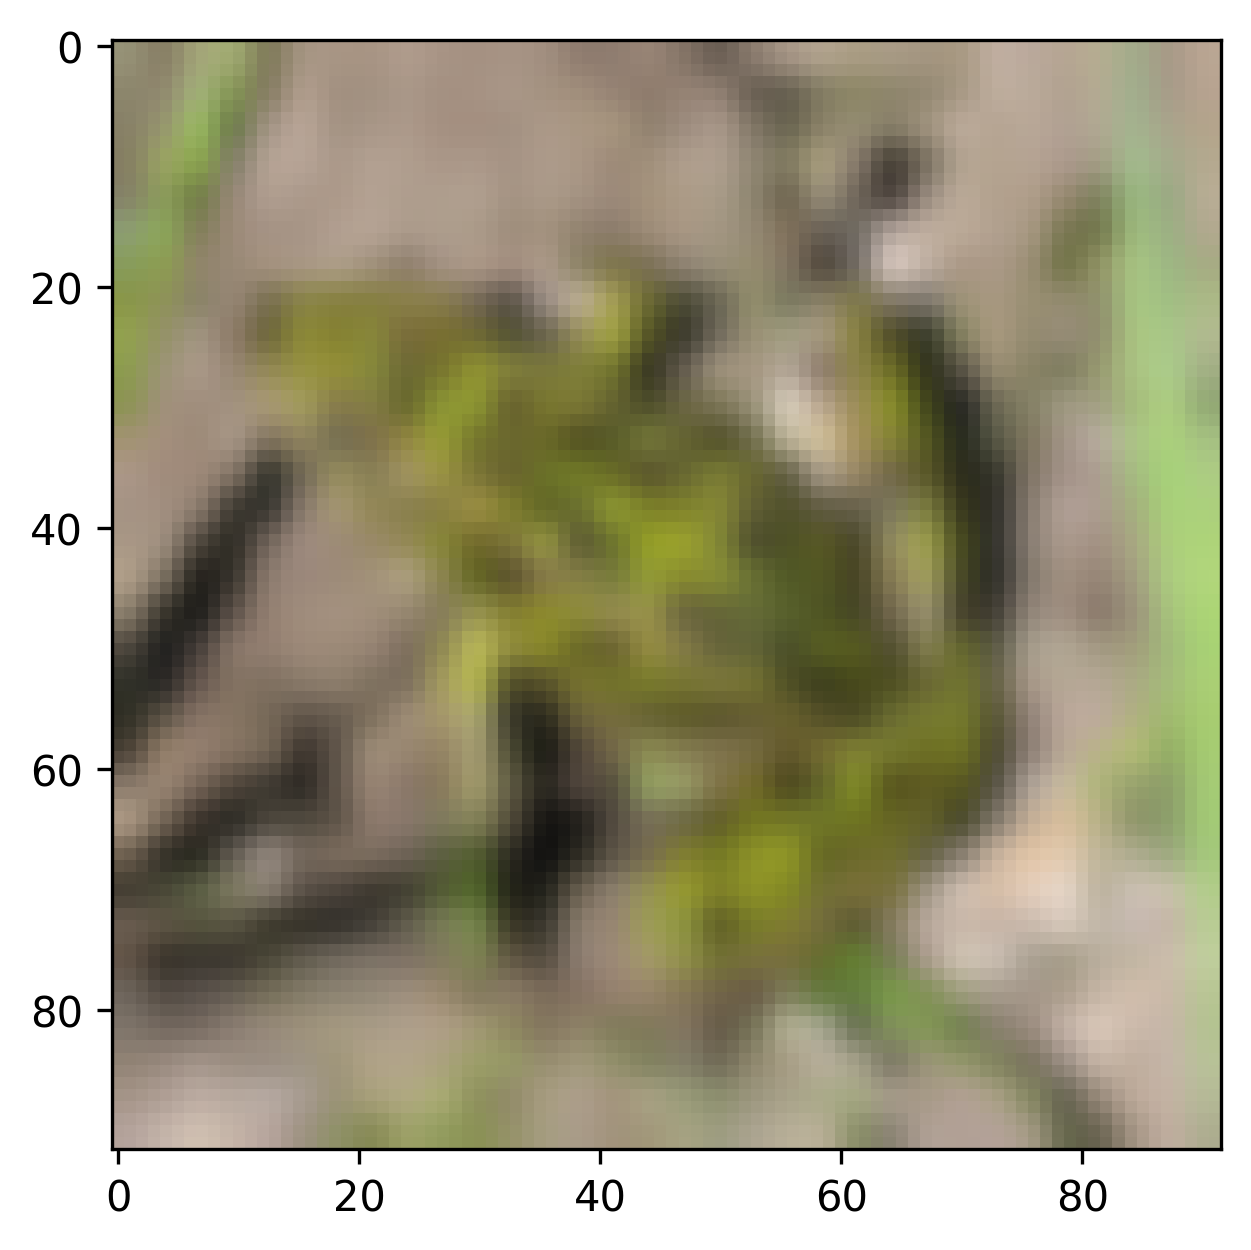

In [ ]:
 # only if you are curious to see what images look like
 #Xh, l = process_image(x_train[1550],y_train[1550])
 #Xh = tf.cast(Xh, tf.uint8)
 plt.imshow(x_train[1550]/255)

In [ ]:
class_names[np.argmax(y_train[1550])]

'frog'

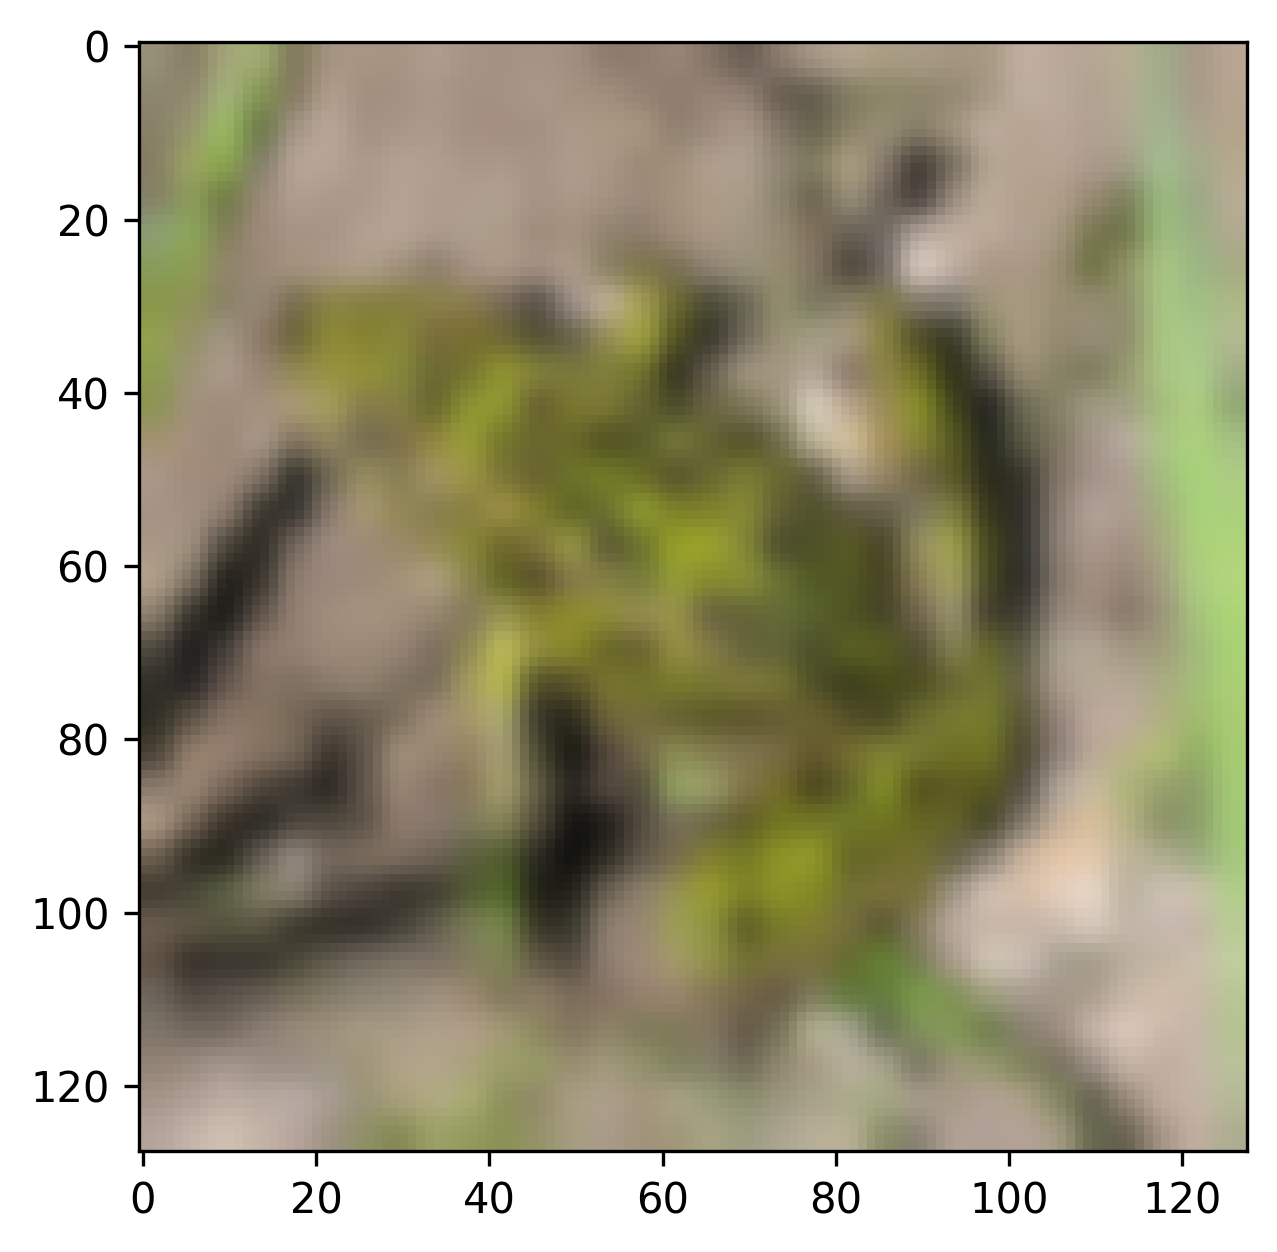

In [ ]:
from pandas import Int8Dtype
plt.imshow(x_train[1550].numpy().astype('uint8'))
plt.imsave('data/frog/image.png',x_train[1550].numpy().astype('uint8'))

In [ ]:
class_names[np.argmax(y_train[123])]

'bird'

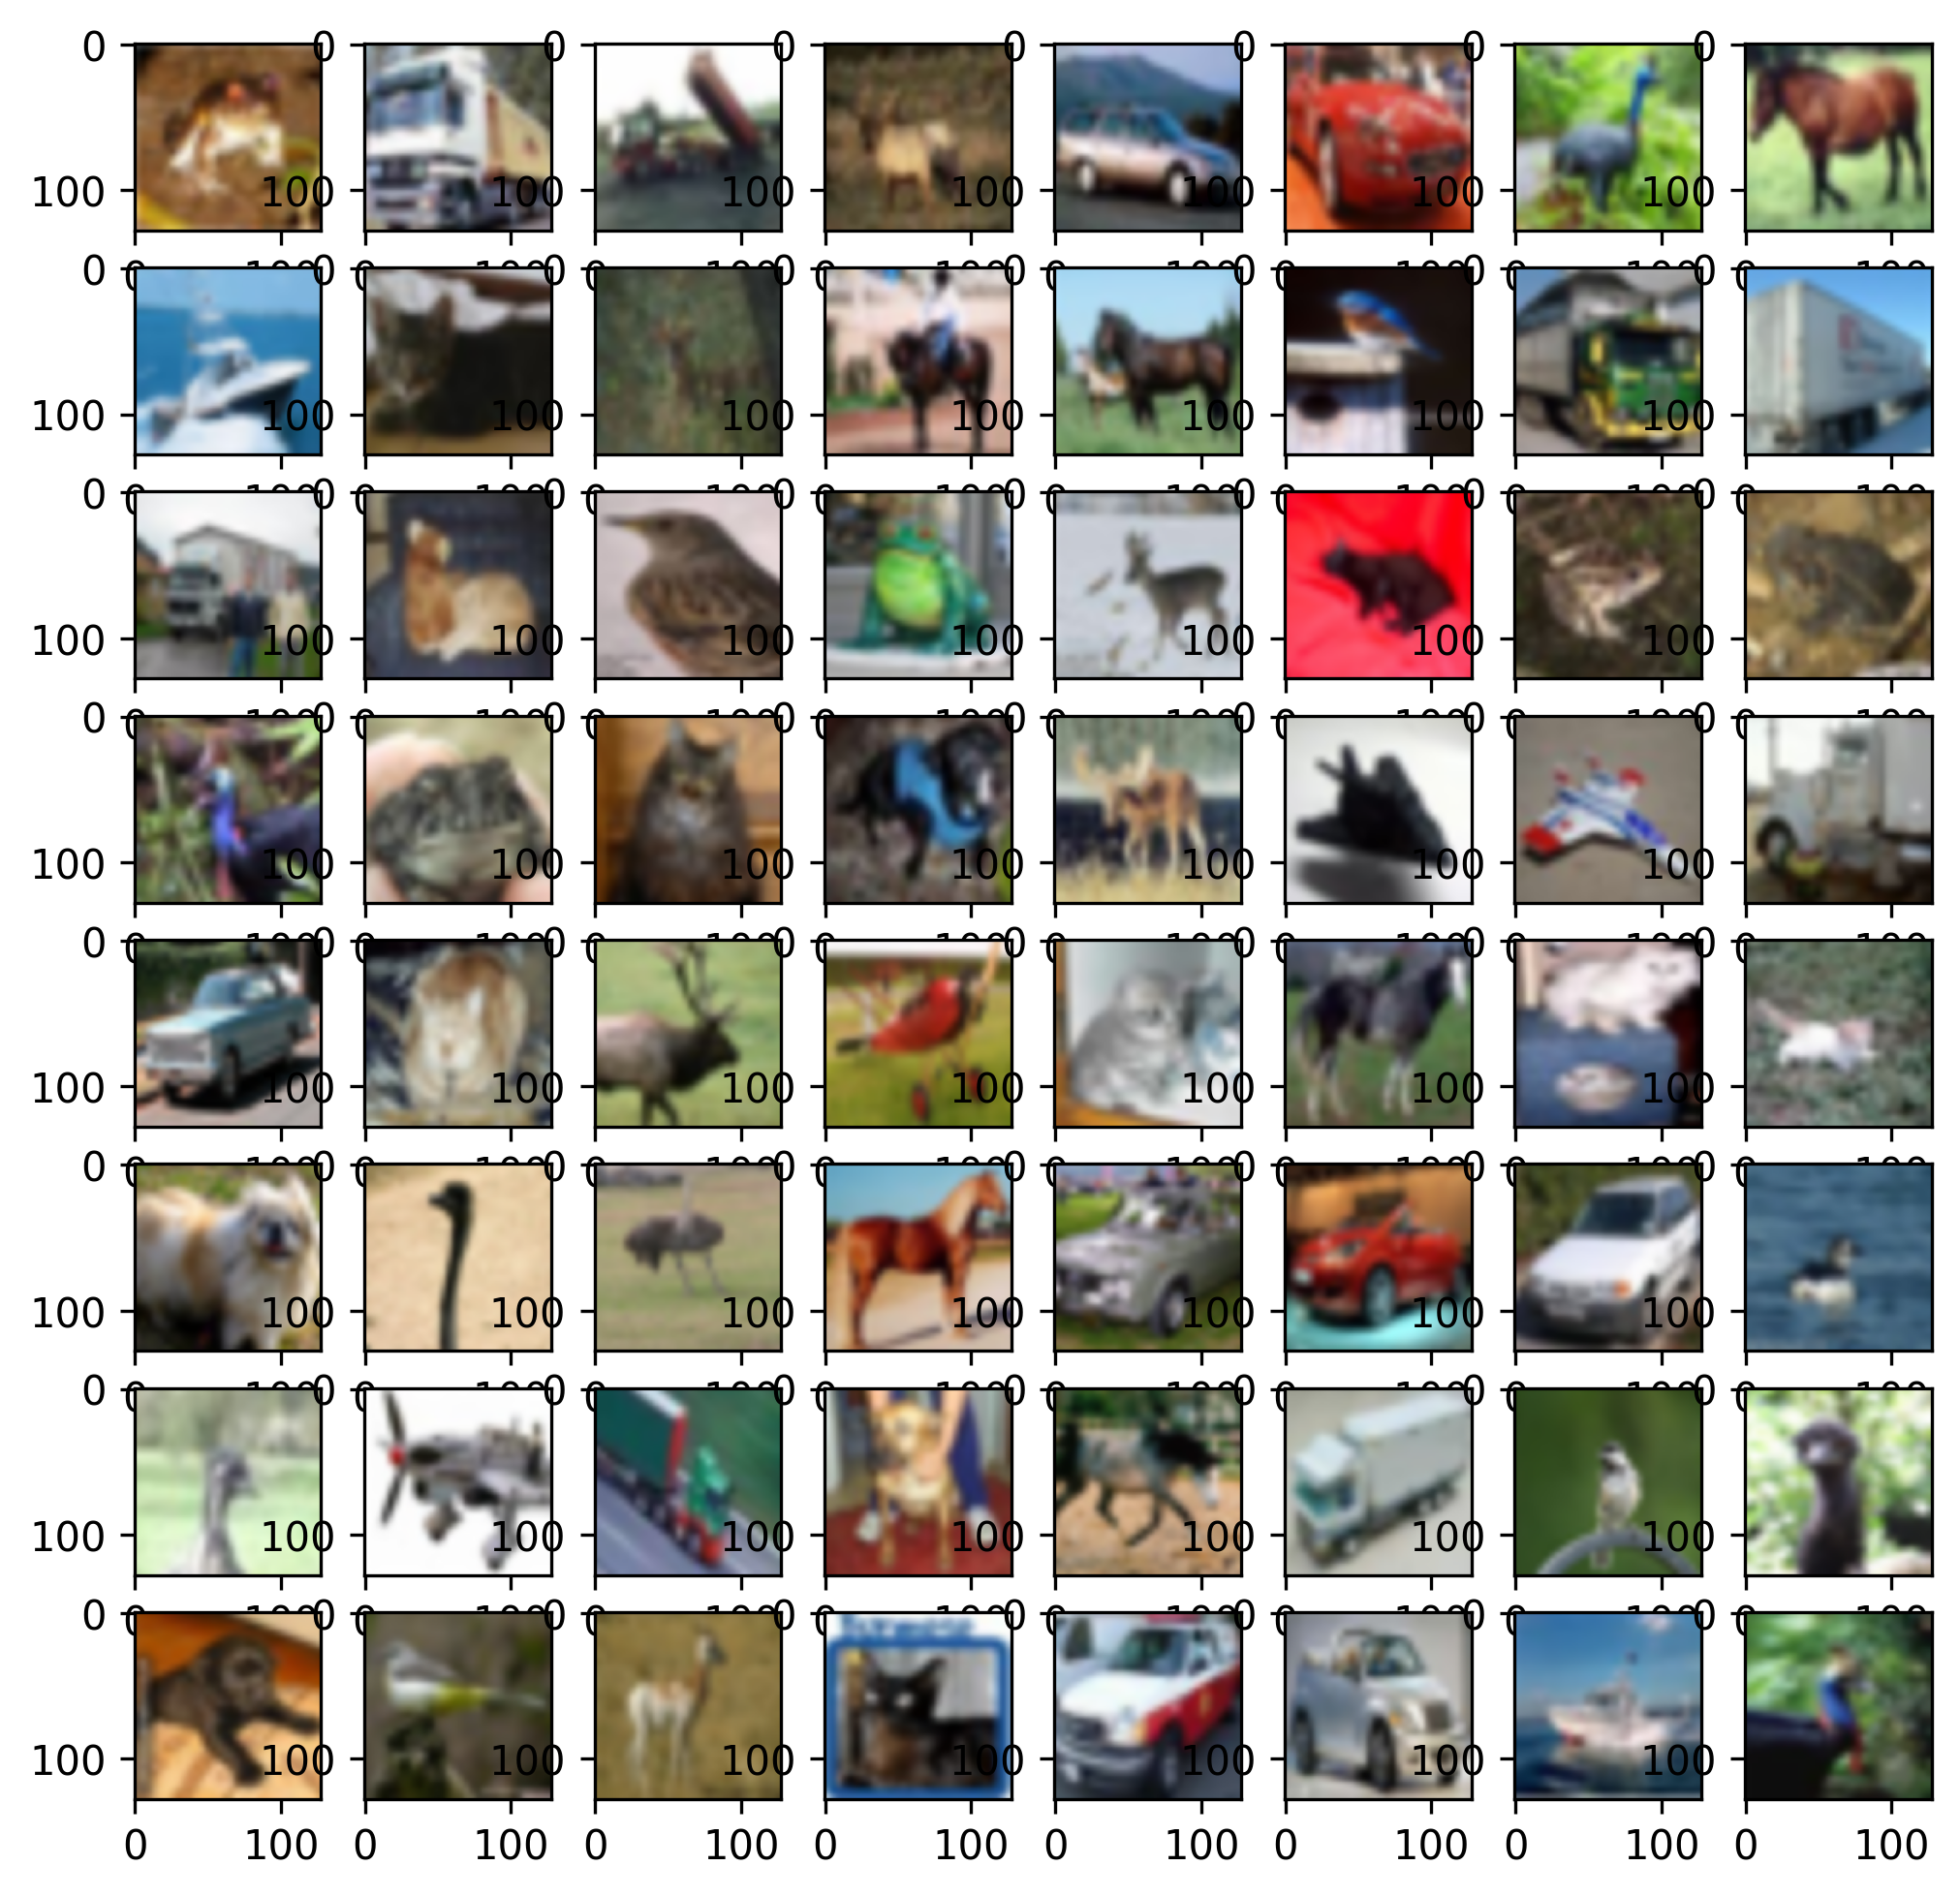

In [ ]:
plt.subplots(figsize=(8,8))
for i in range(64):
	# define subplot
	plt.subplot(8,8,i+1)
	# plot raw pixel data
	plt.imshow(x_train[i].numpy().astype('uint8'))
# show the figure
plt.show()

## We can also improve the classification via interpretable deformations

In [ ]:
aug = ImageDataGenerator(
	rotation_range=18,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")


## Only if you want to save the geometric transformations

Here to visualize the effect of data augmentation you can create the following folder structure:

data
  - bird (or name of the animal/object)
      - (here you save your image in .png format)


output

In [ ]:
pwd

'/content'

In [ ]:
# the workflow of the imagegen

In [ ]:
dir_It = aug.flow_from_directory(
    "data/",
    batch_size=1,
    save_to_dir="output/",
    save_prefix="",
    save_format='png',
)

Found 1 images belonging to 2 classes.


In [ ]:
for _ in range(12):
    img, label = dir_It.next()
    print(img.shape)
    plt.imshow(img[0]/255)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
data_augmentation = True

In [ ]:
train_ds_size=x_train.shape[0]
test_ds_size=x_test.shape[0]
print('Train size:',train_ds_size)
print('Test size:',test_ds_size)

Train size: 50000
Test size: 10000


In [ ]:
x_train.shape

TensorShape([50000, 128, 128, 3])

In [ ]:
train_ds=tf.data.Dataset.from_tensor_slices((x_train,y_train))
test_ds=tf.data.Dataset.from_tensor_slices((x_test,y_test))

In [ ]:
train_ds=(train_ds
          .map(process_image)
          .shuffle(buffer_size=train_ds_size)
          .batch(batch_size=32,drop_remainder=True)
         )
test_ds=(test_ds
          .map(process_image)
          .shuffle(buffer_size=test_ds_size)
          .batch(batch_size=32,drop_remainder=True)
         )

In [ ]:
data_augmentation

True

In [ ]:
# the design of the Deep Learning model
model_cifar10 = Sequential()
# deep learning starts here
model_cifar10.add(Conv2D(filters=128,kernel_size=(11, 11), padding='same',input_shape=x_train.shape[1:]))
model_cifar10.add(BatchNormalization())
model_cifar10.add(MaxPooling2D(pool_size=(2,2)))
model_cifar10.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"))
model_cifar10.add(BatchNormalization())
model_cifar10.add(MaxPooling2D(pool_size=(3,3)))
#model_cifar10.add(BatchNormalization())
model_cifar10.add(Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"))
model_cifar10.add(BatchNormalization())
model_cifar10.add(Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"))
model_cifar10.add(BatchNormalization())
model_cifar10.add(MaxPooling2D(pool_size=(2,2)))
# the features learned by Deep Learning strata are passed to the "Thinking" neurons
model_cifar10.add(Flatten())

# the following are the layers helping with the classification on the previously trained deformations
model_cifar10.add(Dense(1024,activation='gelu'))
model_cifar10.add(Dropout(0.3))
model_cifar10.add(Dense(1024,activation='gelu'))
model_cifar10.add(Dropout(0.3))

# the following is the output layer
model_cifar10.add(Dense(10,activation='softmax'))

# initiate optimizer
opt = Adam(learning_rate=0.001)

# Let's train the model using the chosen optimizer
model_cifar10.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [ ]:
y_train # no need to use again one- hot encoding

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
# fitting the model

if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        #zca_whitening=False,  # apply ZCA whitening
        #zca_epsilon=1e-05,  # epsilon for ZCA whitening
        rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.15,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.15,
        shear_range=0.15,  # set range for random shear
        zoom_range=0.15,  # set range for random zoom
        channel_shift_range=0.15,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.15,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.2)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model_cifar10.fit(datagen.flow(x_train, y_train),
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              workers=8)

# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# Score trained model.
scores = model_cifar10.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Using real-time data augmentation.
Epoch 1/50
1563/1563 [==============================] - 82s 52ms/step - loss: 0.5274 - accuracy: 0.8232 - val_loss: 0.5103 - val_accuracy: 0.8293
Epoch 2/50
1563/1563 [==============================] - 81s 51ms/step - loss: 0.5262 - accuracy: 0.8241 - val_loss: 0.4913 - val_accuracy: 0.8339
Epoch 3/50
1563/1563 [==============================] - 80s 51ms/step - loss: 0.5246 - accuracy: 0.8247 - val_loss: 0.4997 - val_accuracy: 0.8330
Epoch 4/50
1563/1563 [==============================] - 81s 52ms/step - loss: 0.5239 - accuracy: 0.8250 - val_loss: 0.4730 - val_accuracy: 0.8452
Epoch 5/50
1563/1563 [==============================] - 81s 52ms/step - loss: 0.5229 - accuracy: 0.8275 - val_loss: 0.4416 - val_accuracy: 0.8538
Epoch 6/50
1563/1563 [==============================] - 80s 51ms/step - loss: 0.5112 - accuracy: 0.8297 - val_loss: 0.4697 - val_accuracy: 0.8455
Epoch 7/50
1563/1563 [==============================] - 81s 51ms/step - loss: 0.5128 - ac

NameError: ignored

## Test the model with your own images

In [ ]:
import keras.utils as image

In [ ]:
img = image.load_img("image.png",target_size=(128,128))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)

In [ ]:
probs = model_cifar10.predict(img)

1/1 [==============================] - 0s 24ms/step


In [ ]:
probs

array([[0.00127575, 0.00039959, 0.00683096, 0.3444577 , 0.04303416,
        0.00747687, 0.38062876, 0.00890991, 0.20365246, 0.00333386]],
      dtype=float32)

In [ ]:
class_names[np.argmax(probs)]

'frog'

## Pre-trained networks -> Transfer Learning

1/1 [==============================] - 0s 152ms/step


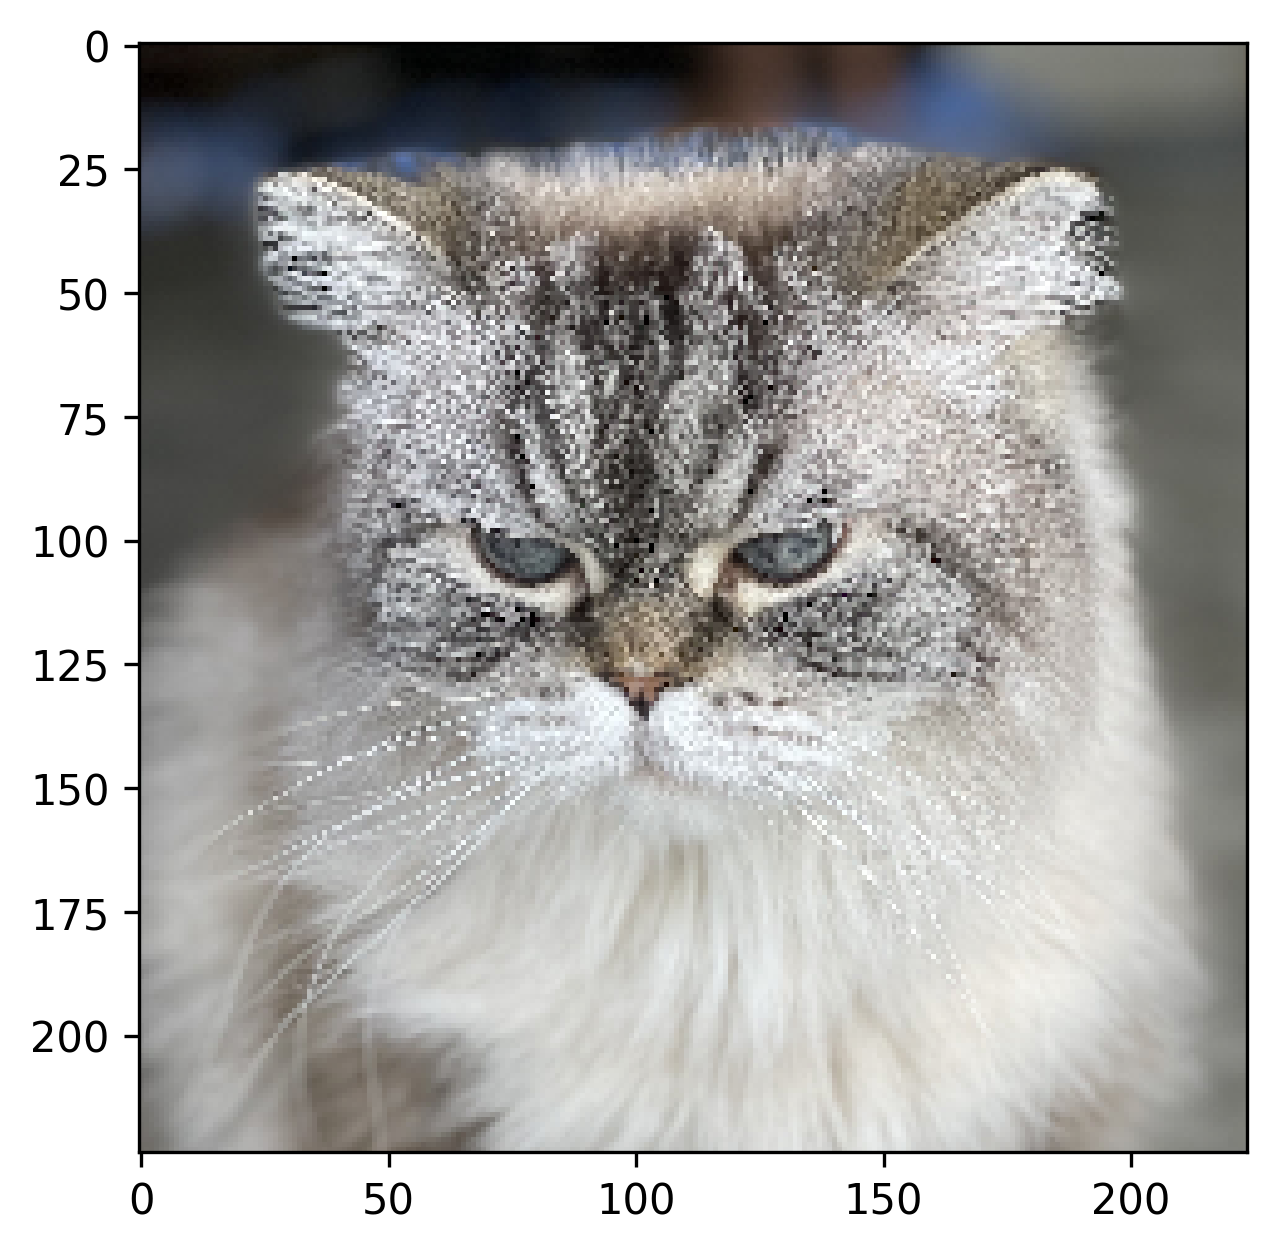

In [ ]:
img = image.load_img("image.png",target_size=(224,224))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)
from keras.applications.vgg16 import VGG16
model = VGG16()
output = model.predict(img)

In [ ]:
output.shape

(1, 1000)

In [ ]:
from keras.applications.vgg16 import decode_predictions
# convert the probabilities to class labels
label = decode_predictions(output)
# retrieve the most likely result, e.g. highest probability
label = label[0][0]
# print the classification
print('%s (%.2f%%)' % (label[1], label[2]*100))

Persian_cat (99.77%)
